d:\Code\PitchExtractor
00_06_46_Pinkie_Angry_Noisy_Well, if you non-earths Aren't gonna stop using your weirdo powers to freeze us all, Then i'm just plumb out of ideas..wav


c:\Users\vul\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


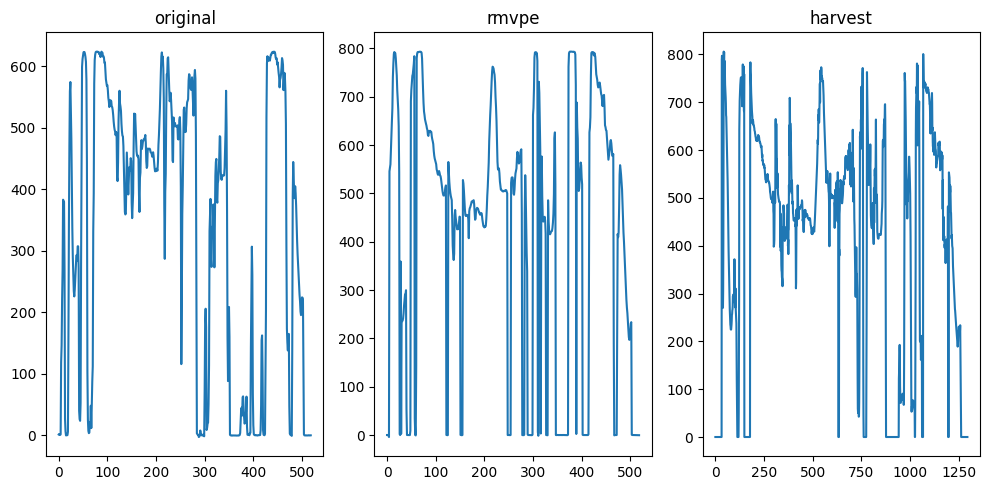

00_26_01_Fluttershy_Neutral__Will you excuse us for a moment_.wav


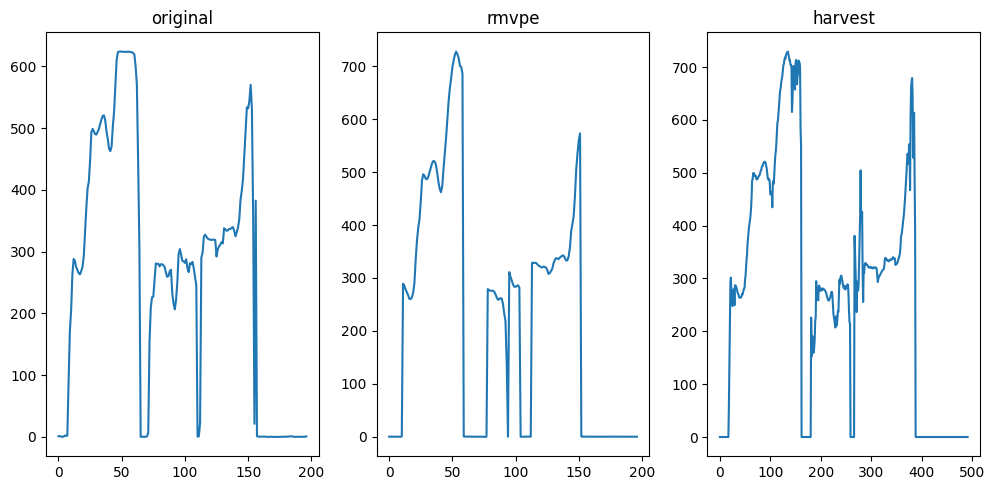

In [14]:
from model import JDCNet
from meldataset import build_dataloader
import torch
import torchaudio
import matplotlib
import os
import soundfile as sf
import pyworld as pw

print(os.getcwd())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = JDCNet(num_class=1)

trial = ["00_06_46_Pinkie_Angry_Noisy_Well, if you non-earths Aren't gonna stop using your weirdo powers to freeze us all, Then i'm just plumb out of ideas..wav",
    "00_26_01_Fluttershy_Neutral__Will you excuse us for a moment_.wav"]

MEL_PARAMS = {
    "n_mels": 80,
    "n_fft": 2048,
    "win_length": 1200,
    "hop_length": 300
}

for f in trial:
    print(f)
    path = os.path.join('StyleTTS2Omnidata',f)
    wave,sr = sf.read(path)
    wave_tensor = torch.from_numpy(wave).float()
    
    x = wave_tensor.numpy().astype("double")
    _f0,t = pw.harvest(x, 24000, MEL_PARAMS['hop_length'] * 1000 / 24000)
    f0_harvest = pw.stonemask(x, _f0, t, 24000)

    to_melspec = torchaudio.transforms.MelSpectrogram(**MEL_PARAMS)
    mel_tensor = to_melspec(wave_tensor)
    mean = -4
    std = 4
    mel_tensor = (torch.log(1e-5 + mel_tensor) - mean) / std
    x = mel_tensor


    mels = torch.zeros((1, x.size(0), x.size(1))).float()
    mels[0, :, :x.size(1)] = x
    mels = mels.unsqueeze(1)
    x = mels

    with torch.no_grad():
        ex = torch.load('Checkpoint/bst.t7')['net']
        model.load_state_dict(ex)
        f0_pred0, sil_pred = model(x.transpose(-1, -2))

        ex2 = torch.load('Checkpoint/bst_rmvpe.t7')['net']
        model.load_state_dict(ex2)
        f0_pred1, sil_pred = model(x.transpose(-1, -2))

    import matplotlib.pyplot as plt
    import numpy as np
    plt.figure(figsize=(10,5))
    plt.subplot(1,3,1)
    plt.plot(f0_pred0.squeeze())
    plt.title('original')
    plt.subplot(1,3,2)
    plt.plot(f0_pred1.squeeze())
    plt.title('rmvpe')
    plt.subplot(1,3,3)
    plt.plot(f0_harvest)
    plt.title('harvest')
    plt.tight_layout()
    plt.show()